In [1]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import mean_absolute_error as mae
mse = nn.MSELoss()
import torch.optim.lr_scheduler as lr_scheduler
device=device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)
alpha = 0.01
beta = 0.5
gamma = 0.5
N = 2000

Euler Maruyama SDE Solver for Data Generation

In [2]:
def Euler_Maruyama(param,dt,n):
    [p1,p2] = param
    S = np.zeros(n)
    S[0] = p1
    I = np.zeros(n)
    I[0] = p2
    R = np.zeros(n)
    for i in range(n-1):
        S[i+1] = S[i] + dt*(-beta*S[i]*I[i])
        I[i+1] = I[i] + dt*(beta*S[i]*I[i] - gamma*I[i]) + alpha*I[i]*np.random.randn(1)*np.sqrt(dt)
        R[i+1] = N - S[i+1]-I[i+1]
    return S,I,R

Pure Physics(Incomplete) model using Euler Maruyama solver

In [3]:
def Physics_pure(param,batch_size,dt,n):
    zp = param
    s_dash = torch.zeros((batch_size,n),dtype = float).to(device) 
    s_dash[:,0] = zp[:,0]*torch.ones((batch_size), dtype = float).to(device)
    
    I_dash = torch.zeros((batch_size,n),dtype = float).to(device) 
    I_dash[:,0] = zp[:,1]*torch.ones((batch_size), dtype = float).to(device)
    
    R_dash = torch.zeros((batch_size,n),dtype = float).to(device) 
    
    dT = 0.001 * torch.ones(batch_size).to(device)
    dW = torch.sqrt(dT)*torch.randn(batch_size).to(device)
    for i in range(n-1):
        s_dash[:,i+1] = s_dash[:,i] + dT*(-beta *s_dash[:,i]*I_dash[:,i])
        I_dash[:,i+1] = I_dash[:,i] + dT*( gamma*I_dash[:,i]) + dW
        R_dash[:,i+1] = N - s_dash[:,i+1]-I_dash[:,i+1]
    return I_dash

Data Generation

1391.9233456530737
(3500, 100)
prm (3500, 2)


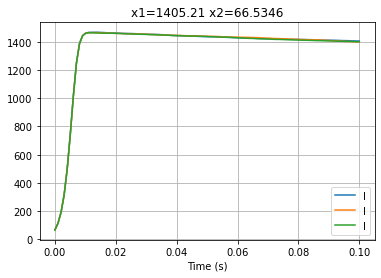

In [4]:
#Uniform random initialization for 3500 data points
S0 = np.random.uniform(1200,1800,3500)
I0 = np.random.uniform(20,200,3500)
print(S0[2])

#Standard Deviation for S0 and I0
std_x1 = np.std(S0)
std_x2 = np.std(I0)

#Time discretization domain
t = np.linspace(0,0.1,100)
dt = t[2]-t[1]

#Initialising output matrices
X = np.zeros([3500,100])
Y = np.zeros([3500,100])
Z = np.zeros([3500,100])

#Initialising parameters matrix
prm = np.zeros([3500,2]) 

for i in range(3500):
    if i%50 == 0:
        p1 = S0[i]
        p2 = I0[i]
    param = [p1,p2]
    X[i,:],Y[i,:],Z[i,:]= Euler_Maruyama(param,dt,100)
    prm[i] = param
print(np.shape(Y))
print("prm",prm.shape)

#plot output
plt.figure(1)
plt.plot(t, Y[10,:], label='I')
plt.plot(t, Y[11,:], label='I')
plt.plot(t, Y[12,:], label='I')
txt = "x1="+str(prm[10,0])[0:7]+" x2=" + str(prm[10,1])[0:7]
plt.title(label=txt)
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)

[1405.21156511   66.5346284 ]


<AxesSubplot:ylabel='Density'>

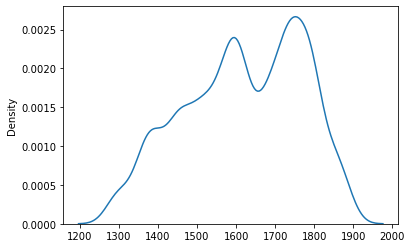

In [6]:
#Pdf plot of generated data at a particular time step
Y_at_t = Y[:,33]
print(prm[0])
sns.kdeplot(Y_at_t)

In [8]:
#Preparing training dataset and dataloader
train_data = torch.from_numpy(Y[0:2000,:]).to(device)
train_prm  = torch.from_numpy(prm[0:2000,:]).to(device)

Train_data = TensorDataset(train_data,train_prm)
Train_dl = DataLoader(Train_data, batch_size=50, shuffle=False)# We didn’t shuffle the data

Deep Neural network for proposed model
<br>
S_dash : number of susceptible individuals 
<br>
I_dash : number of infected individuals
<br>
R_dash : number of recovered individuals

In [9]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        # Neural network that will fill in for diffusion term
        self.fA1 = nn.Sequential(nn.Linear(14, 64),
                                 nn.ELU(),
                                 nn.Linear(64 ,256),
                                 nn.ELU(),
                                 nn.Linear(256,512),
                                 nn.ELU(),
                                 nn.Linear(512,256),
                                 nn.ELU(),
                                 nn.Linear(256, 64),
                                 nn.ELU(),
                                 nn.Linear(64,1))


    def forward(self, batch_size, params,n):
        zp = params
        
        #Initializing the solution matrices
        S_dash = torch.zeros((batch_size,n),dtype = float).to(device)
        I_dash = torch.zeros((batch_size,n),dtype = float).to(device)
        R_dash = torch.zeros((batch_size,n),dtype = float).to(device)
        
        #As the initial condition S_dash and I_dahs(@ t=0) = S0 and I0, assigning first column of matrices = initial condition
        S_dash[:,0] = zp[:,0]*torch.ones((batch_size), dtype = float).to(device)
        I_dash[:,0] = zp[:,1]*torch.ones((batch_size), dtype = float).to(device)
      
        #Loop for time marching
        for i in range(n-1):
            S = torch.reshape(S_dash[:,i],(batch_size,1))
            I = torch.reshape(I_dash[:,i],(batch_size,1))
            
            # Taking sample for Z(random variable) from standard gaussian distribution
            z_A1 = torch.randn(batch_size,10).to(device)
            
            #Taking out 1st column out from the parameters i.e S0 and calling it z_p0
            z_p0 = torch.reshape(zp[:,0],(batch_size,1))
            
            #Taking out 2nd column out from the parameters i.e I0 and calling it z_p1
            z_p1 = torch.reshape(zp[:,1],(batch_size,1))
            
            #Input to the Neural network that will fill in for the unknown part
            input_fA1 = torch.cat((z_A1,I,S,z_p0,z_p1),1).to(device)
            
            # Outputs from the neural networks
            fA1_loc = self.fA1(input_fA1)
            
            #Resize
            fA1_loc_ = torch.squeeze(fA1_loc)
            
            # Time as tensor  of size = batch size
            dT = dt * torch.ones(batch_size).to(device)
            
            # White noise as tensor of size = batch size
            dW = torch.sqrt(dT)*torch.randn(batch_size).to(device)
            
            
            # Using explicit Euler Maruyama to compute the output at (i+1)th step given the ith step output(I_dash)
            S_dash[:,i+1] = S_dash[:,i] + dT*(-beta*S_dash[:,i].clone()*I_dash[:,i].clone())
            #I_dash[:,i+1] = I_dash[:,i] + dt*(zp[:,0]*S_dash[:,i]*I_dash[:,i] - zp[:,1]*I_dash[:,i]) + alpha*I_dash[:,i]*dW
            I_dash[:,i+1] = I_dash[:,i] + dT*(beta*S_dash[:,i].clone()*I_dash[:,i].clone() - gamma*I_dash[:,i]) + fA1_loc_*dW
            R_dash[:,i+1] = N - S_dash[:,i+1]-I_dash[:,i+1]
         
        s_hat = I_dash
        
        return s_hat, zp

Neural Network for purely data driven solver

In [10]:
class Datadriven(nn.Module):
    def __init__(self):
        super(Datadriven,self).__init__()
        self.network1 = nn.Sequential(nn.Linear(13, 64),
                                 nn.ELU(),
                                 nn.Linear(64 ,256),
                                 nn.ELU(),
                                 nn.Linear(256,512),
                                 nn.ELU(),
                                 nn.Linear(512,256),
                                 nn.ELU(),
                                 nn.Linear(256, 64),
                                 nn.ELU(),
                                 nn.Linear(64,1))
    
    def forward(self, batch_size, params,time):
        Z = torch.randn(batch_size,10).to(device)
        network_input = torch.cat((params,Z,time),1).to(device)
        output  = self.network1(network_input)
        out = torch.squeeze(output)
        return out

CMMD Loss Function

In [11]:
def gram_matrix(x, y, gamma1, pi1):
    sq_dist = torch.sum((torch.unsqueeze(x, 1)-torch.unsqueeze(y, 0))**2,2)      
    kernel = (pi1*torch.exp(-gamma1*sq_dist))
    return  kernel

In [12]:
def multidot(A,B,C,D):

  return torch.tensordot(A,torch.tensordot(B,torch.tensordot(C,D,dims=1),dims=1),dims=1)

In [13]:
def CMMD_loss(x_comp, x_hat, params, zp):
        gamma1 = torch.sigmoid(lambda1)
        #Mixture Coefficients   
        pi1 = torch.exp(beta1).to(device)
        #Gram Matrices
        k_d = gram_matrix(params, params, gamma1, pi1)
        #print('k_d',k_d.shape)
        k_s = gram_matrix(zp, zp, gamma1, pi1)
        #print('k_s',k_s)
        l_d = gram_matrix(x_comp, x_comp, gamma1, pi1)
        #print('l_d',l_d)
        l_s = gram_matrix(x_hat, x_hat, gamma1, pi1)
        #print('l_s',l_s)
        k_sd = gram_matrix(params,zp, gamma1, pi1)
        #print('k_sd',k_sd)
        l_ds = gram_matrix(x_comp, x_hat, gamma1, pi1)
        #print('l_ds',l_ds)
        lam = 2.0 #hyperparameteR
        row, col = k_d.shape
        k_d_tilda = k_d + (lam*torch.eye(row,col,device="cuda"))
        #print( 'k_d_tild',k_d_tilda)
        k_s_tilda = k_s + (lam*torch.eye(row,col,device="cuda"))
        #print(' k_s_tilda',k_s_tilda)
        k_sd_tilda = k_sd + (lam*torch.eye(row,col,device="cuda"))
        #print('k_sd_tilda',k_sd_tilda)
        loss = torch.sqrt(torch.trace(multidot(k_d,torch.inverse(k_d_tilda),l_d,torch.inverse(k_d_tilda))) + torch.trace(multidot(k_s,torch.inverse(k_s_tilda),l_s,torch.inverse(k_s_tilda))) - 2*torch.trace(multidot(k_sd,torch.inverse(k_d_tilda),l_ds,torch.inverse(k_s_tilda))))
        #print('shape',loss.shape)
        return loss 

Training function for the proposed model

In [14]:
def train_CMMD(model_dpc, epochs):
    opt = torch.optim.Adam(model_dpc.parameters(),lr = .000001)
    train_loss_epochs = torch.empty((epochs)).to(device)
    scheduler = lr_scheduler.StepLR(opt, step_size = 50, gamma=0.9, verbose = True)
    for epoch in range(epochs):
        print(epoch)
        a=1
        b=1
        c=10
        i=0
        train_cum_loss = 0
        for batch,params in Train_dl:
           s = batch
           params = params[:,0:2]
           #print("params",params.shape)
           batch_size = s.shape[0]
           x1 = params[:,0] # since params is taking new set of values every iterations 
           #print("omega",omega.shape)
           x2 =  params[:,1]
           opt.zero_grad()
           s_hat,zp = model_dpc(batch_size=batch_size, params = params, n=100)
           i=+1
           loss_CMMD = CMMD_loss(s, s_hat, params, params)
           loss_rec = ((s - s_hat)**2).sum()
           loss = a*loss_CMMD 
           train_cum_loss+=loss
           loss.backward()
           opt.step()
        scheduler.step()
        train_loss_epochs[epoch] = train_cum_loss/2000 ########bATCH_SIZE
        print("loss_CMMD",loss_CMMD)
        print("loss_rec",loss_rec)
    return model_dpc, train_loss_epochs,opt

Training function for pure-data driven model

In [18]:
def train_CMMD_new(model_dpc, epochs):
    opt = torch.optim.Adam(model_dpc.parameters(),lr = .00001)
    train_loss_epochs = torch.empty((epochs)).to(device)
    scheduler = lr_scheduler.StepLR(opt, step_size = 100, gamma=0.99, verbose = True)
    for epoch in range(epochs):
        print(epoch)
        a=1
        b=1
        c=10
        i=0
        n = 100
        train_cum_loss = 0
        for batch,params in Train_dl:
           s = batch
           params = params[:,0:2]
           #print("params",params.shape)
           batch_size = s.shape[0]
           s_hat = torch.zeros((batch_size,n), dtype = float).to(device)
           x1 = params[:,0] # since params is taking new set of values every iterations 
           #print("omega",omega.shape)
           x2 =  params[:,1]
           opt.zero_grad()
           for t in range(100):
              time = t*dt*torch.ones((batch_size,1), dtype = float).to(device)
              s_hat[:,t] = model(batch_size=batch_size, params = params, time = time)
           i=+1
           loss_CMMD = CMMD_loss(s, s_hat, params, params)
           loss_rec = ((s - s_hat)**2).sum()
           loss = a*loss_rec
           train_cum_loss+=loss
           loss.backward()
           opt.step()
        scheduler.step()
        train_loss_epochs[epoch] = train_cum_loss/2000 ########bATCH_SIZE
        print("loss_CMMD",loss_CMMD)
        print("loss_rec",loss_rec)
    return model, train_loss_epochs,opt

Test function for the proposed DPC model

In [19]:
def test(model_dpc,n):
    S0 = np.random.uniform(1200,1800,1500)
    I0 = np.random.uniform(20,200,1500)
    t = np.linspace(0,0.1,100)
    dt = t[2]-t[1]
    X1  = np.zeros([1500,n])
    Y1  = np.zeros([1500,n])
    Z1 = np.zeros([1500,n])
    prm_test = np.zeros([1500,2]) 
    for i in range(1500):
        p1 = S0[i]
        p2 = I0[i]
        param = [p1,p2]
        X1[i,:],Y1[i,:],Z1[i,:]= Euler_Maruyama(param,dt,n)
        prm_test[i] = param
    print(Y1.shape)
    print(prm_test.shape)
    test_data1 = torch.from_numpy(Y1).to(device) 
    test_prm1 = torch.from_numpy(prm_test).to(device)
    Test_data1 = TensorDataset(test_data1,test_prm1)
    Test_dl_1 = DataLoader(Test_data1, batch_size=50, shuffle=False)
    with torch.no_grad():  
        s_full =  torch.empty(1500,n)
        s_hat_full =  torch.empty(1500,n)
        parameters =  torch.empty(1500,2) 
        i=0
    for batch,p in Test_dl_1:
        s = batch
        #print("s_shape",s.shape)
        batch_size = s.shape[0]
        parameters[i*batch_size:(i+1)*batch_size,:] = p
        #print(batch_size)
        s_full[i*batch_size:(i+1)*batch_size,:] = s
        s_hat,zp = model_dpc(batch_size=batch_size, params = p, n=n)
        s_hat_full[i*batch_size:(i+1)*batch_size,:] = s_hat
        i+=1
    x_hat = s_hat_full.cpu()
    X_hat = x_hat.detach().numpy()
    x = s_full.cpu()
    X= x.detach().numpy()
    er = mae = np.absolute(np.subtract(X_hat, X)).mean() 

    return er,parameters,X_hat,X

Test function for the all the models combined i.e the DPC model, pure physics and pure data driven model

In [20]:
def test1(model_dpc, model, n):
    S0 = np.random.uniform(1200,1800,1500)
    I0 = np.random.uniform(20,200,1500)
    t = np.linspace(0,0.1,100)
    dt = t[2]-t[1]
    X1  = np.zeros([1500,n])
    Y1  = np.zeros([1500,n])
    Z1 = np.zeros([1500,n])
    prm_test = np.zeros([1500,2]) 
    for i in range(1500):
        p1 = S0[i]
        p2 = I0[i]
        param = [p1,p2]
        X1[i,:],Y1[i,:],Z1[i,:]= Euler_Maruyama(param,dt,n)
        prm_test[i] = param
    print(Y1.shape)
    print(prm_test.shape)
    test_data1 = torch.from_numpy(Y1).to(device) 
    test_prm1 = torch.from_numpy(prm_test).to(device)
    Test_data1 = TensorDataset(test_data1,test_prm1)
    Test_dl_1 = DataLoader(Test_data1, batch_size=1500, shuffle=False)
    with torch.no_grad():  
        s_full =  torch.empty(1500,n)
        s_hat_full =  torch.empty(1500,n)
        s_hat_full_data = torch.empty(1500,n)
        s_hat_full_physics = torch.empty(1500,n)
        parameters =  torch.empty(1500,2) 
        i=0
    for batch,p in Test_dl_1:
        s = batch
        #print("s_shape",s.shape)
        batch_size = s.shape[0]
        parameters[i*batch_size:(i+1)*batch_size,:] = p
        #print(batch_size)
        s_full[i*batch_size:(i+1)*batch_size,:] = s
        s_hat,zp = model_dpc(batch_size=batch_size, params = p, n=n)
        for t in range(n):
            time = t*dt*torch.ones((batch_size,1), dtype = float).to(device)
            s_hat_full_data[:,t] = model(batch_size=batch_size, params = p, time = time)   
        s_hat_full[i*batch_size:(i+1)*batch_size,:] = s_hat
        s_hat_full_physics = Physics_pure(p,batch_size, dt, n) 
        i+=1
    x_hat = s_hat_full.cpu()
    X_hat = x_hat.detach().numpy()
    x_hat_data = s_hat_full_data.cpu()
    X_hat_data = x_hat_data.detach().numpy()
    x_hat_physics = s_hat_full_physics.cpu()
    X_hat_physics = x_hat_physics.detach().numpy()
    x = s_full.cpu()
    X= x.detach().numpy()
    er = mae = np.absolute(np.subtract(X_hat, X)).mean() 

    return er, parameters, X_hat, X_hat_data, X_hat_physics, X

Main: Training of the proposed model till convergence is reached


Adjusting learning rate of group 0 to 1.0000e-06.
0
Adjusting learning rate of group 0 to 1.0000e-06.
loss_CMMD tensor(0.2000, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(36261.9482, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
1
Adjusting learning rate of group 0 to 1.0000e-06.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(43587.6297, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
2
Adjusting learning rate of group 0 to 1.0000e-06.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(50730.3561, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
3
Adjusting learning rate of group 0 to 1.0000e-06.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(51062.2023, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
4
Adju

Adjusting learning rate of group 0 to 1.0000e-06.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(44553.8970, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
36
Adjusting learning rate of group 0 to 1.0000e-06.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(42771.4241, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
37
Adjusting learning rate of group 0 to 1.0000e-06.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(42099.6046, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
38
Adjusting learning rate of group 0 to 1.0000e-06.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(47630.0908, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
39
Adjusting learning rate of group 0 to 1.0000e-06.
lo

Adjusting learning rate of group 0 to 9.0000e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(55629.4320, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
71
Adjusting learning rate of group 0 to 9.0000e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(53566.6790, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
72
Adjusting learning rate of group 0 to 9.0000e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(52141.8052, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
73
Adjusting learning rate of group 0 to 9.0000e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(54248.7544, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
74
Adjusting learning rate of group 0 to 9.0000e-07.
lo

Adjusting learning rate of group 0 to 8.1000e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(57141.0655, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
106
Adjusting learning rate of group 0 to 8.1000e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(54937.3993, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
107
Adjusting learning rate of group 0 to 8.1000e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(46592.6017, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
108
Adjusting learning rate of group 0 to 8.1000e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(45942.0674, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
109
Adjusting learning rate of group 0 to 8.1000e-07

Adjusting learning rate of group 0 to 8.1000e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(58899.7050, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
141
Adjusting learning rate of group 0 to 8.1000e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(46780.5161, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
142
Adjusting learning rate of group 0 to 8.1000e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(52160.2484, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
143
Adjusting learning rate of group 0 to 8.1000e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(49612.4528, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
144
Adjusting learning rate of group 0 to 8.1000e-07

Adjusting learning rate of group 0 to 7.2900e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(61673.6215, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
176
Adjusting learning rate of group 0 to 7.2900e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(51617.3700, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
177
Adjusting learning rate of group 0 to 7.2900e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(62777.3597, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
178
Adjusting learning rate of group 0 to 7.2900e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(51934.0769, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
179
Adjusting learning rate of group 0 to 7.2900e-07

Adjusting learning rate of group 0 to 6.5610e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(58192.0704, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
211
Adjusting learning rate of group 0 to 6.5610e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(53101.6836, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
212
Adjusting learning rate of group 0 to 6.5610e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(56643.4434, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
213
Adjusting learning rate of group 0 to 6.5610e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(55737.6690, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
214
Adjusting learning rate of group 0 to 6.5610e-07

Adjusting learning rate of group 0 to 6.5610e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(56676.0966, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
246
Adjusting learning rate of group 0 to 6.5610e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(57432.1567, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
247
Adjusting learning rate of group 0 to 6.5610e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(62597.2470, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
248
Adjusting learning rate of group 0 to 6.5610e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(51612.3748, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
249
Adjusting learning rate of group 0 to 5.9049e-07

Adjusting learning rate of group 0 to 5.9049e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(62139.1823, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
281
Adjusting learning rate of group 0 to 5.9049e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(57645.1739, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
282
Adjusting learning rate of group 0 to 5.9049e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(66312.6225, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
283
Adjusting learning rate of group 0 to 5.9049e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(57688.8364, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
284
Adjusting learning rate of group 0 to 5.9049e-07

Adjusting learning rate of group 0 to 5.3144e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(55599.2396, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
316
Adjusting learning rate of group 0 to 5.3144e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(49788.3318, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
317
Adjusting learning rate of group 0 to 5.3144e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(60614.6768, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
318
Adjusting learning rate of group 0 to 5.3144e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(56406.5782, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
319
Adjusting learning rate of group 0 to 5.3144e-07

Adjusting learning rate of group 0 to 4.7830e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(53853.2856, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
351
Adjusting learning rate of group 0 to 4.7830e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(51320.1998, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
352
Adjusting learning rate of group 0 to 4.7830e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(85659.6142, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
353
Adjusting learning rate of group 0 to 4.7830e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(60373.9292, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
354
Adjusting learning rate of group 0 to 4.7830e-07

Adjusting learning rate of group 0 to 4.7830e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(55399.3659, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
386
Adjusting learning rate of group 0 to 4.7830e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(58983.8095, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
387
Adjusting learning rate of group 0 to 4.7830e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(62875.9368, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
388
Adjusting learning rate of group 0 to 4.7830e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(54000.6911, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
389
Adjusting learning rate of group 0 to 4.7830e-07

Adjusting learning rate of group 0 to 4.3047e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(64062.5366, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
421
Adjusting learning rate of group 0 to 4.3047e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(64936.6978, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
422
Adjusting learning rate of group 0 to 4.3047e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(64062.3820, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
423
Adjusting learning rate of group 0 to 4.3047e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(61541.8281, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
424
Adjusting learning rate of group 0 to 4.3047e-07

Adjusting learning rate of group 0 to 3.8742e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(90869.2014, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
456
Adjusting learning rate of group 0 to 3.8742e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(64444.1079, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
457
Adjusting learning rate of group 0 to 3.8742e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(66649.5696, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
458
Adjusting learning rate of group 0 to 3.8742e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(60934.5621, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
459
Adjusting learning rate of group 0 to 3.8742e-07

Adjusting learning rate of group 0 to 3.8742e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(60929.0114, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
491
Adjusting learning rate of group 0 to 3.8742e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(58860.6387, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
492
Adjusting learning rate of group 0 to 3.8742e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(62945.5332, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
493
Adjusting learning rate of group 0 to 3.8742e-07.
loss_CMMD tensor(0.1999, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(72177.6991, device='cuda:0', dtype=torch.float64,
       grad_fn=<SumBackward0>)
494
Adjusting learning rate of group 0 to 3.8742e-07

Text(0, 0.5, 'Training loss')

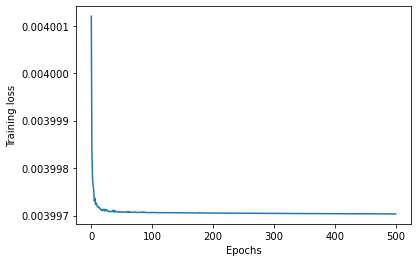

In [16]:
# No of epochs for training
epochs = 750

# lambda1 and beta1 are the parameters in the kernel function used to define the CMMD loss funct
lambda1 = torch.tensor(-0.5, requires_grad = True).to(device)
beta1 = torch.tensor(4.0, requires_grad = True).to(device)

#Included in the training process
lambda1 = torch.nn.Parameter(lambda1)
beta1 = torch.nn.Parameter(beta1)
model_dpc = DNN().to(device)
model_dpc.register_parameter('lanbda11',lambda1)
model_dpc.register_parameter('beta1',beta1)

#Training
model_dpc,train_loss_epochs,opt= train_CMMD(model_dpc.double(),epochs)

#plotting training loss vs number of epochs at the end of the training
epochs_array = np.linspace(0,epochs,epochs)
train_loss_epochs= train_loss_epochs.cpu()
train_loss_epochs= train_loss_epochs.detach().numpy()
fig1=plt.figure(1)
plt.plot(epochs_array ,train_loss_epochs, label="training_loss")
plt.xlabel("Epochs")
plt.ylabel("Training loss")

In [17]:
torch.save(autoencoder.state_dict(), 'PIDecoder_SIR_SDE_2k_Pdiffusion')

Training of pure data-driven model

In [23]:
epochs = 150
lambda1 = torch.tensor(-0.5, requires_grad = True).to(device)
beta1 = torch.tensor(4.0, requires_grad = True).to(device)
lambda1 = torch.nn.Parameter(lambda1)
beta1 = torch.nn.Parameter(beta1)
model = Datadriven().to(device)
model.register_parameter('lanbda11',lambda1)
model.register_parameter('beta1',beta1)

model,train_loss_epochs,opt= train_CMMD_new(model.double(),epochs)
epochs_array = np.linspace(0,epochs,epochs)
train_loss_epochs= train_loss_epochs.cpu()
train_loss_epochs= train_loss_epochs.detach().numpy()
fig1=plt.figure(1)
plt.plot(epochs_array ,train_loss_epochs, label="training_loss")
plt.xlabel("Epochs")
plt.ylabel("Training loss")

Adjusting learning rate of group 0 to 1.0000e-05.
0


KeyboardInterrupt: 

In [56]:
torch.save(model.state_dict(), 'PIDecoder_SIR_SDE_2k_Pdiffusion_data1')

Plots of pdf for all the models within  the training window

(1500, 1000)
(1500, 2)


<Figure size 432x288 with 0 Axes>

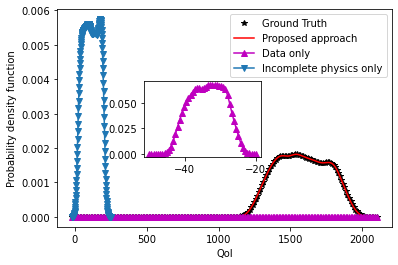

In [21]:
with torch.no_grad():  
    device = torch.device("cuda")
    lambda1 = torch.tensor(-0.5, requires_grad = True).to(device)
    beta1 = torch.tensor(4.0, requires_grad = True).to(device)
    lambda1 = torch.nn.Parameter(lambda1)
    beta1 = torch.nn.Parameter(beta1)
    model_dpc = DNN().to(device)
    model_dpc.register_parameter('lanbda11',lambda1)
    model_dpc.register_parameter('beta1',beta1)
    model_dpc.load_state_dict(torch.load('PIDecoder_SIR_SDE_2k_Pdiffusion'))
    model_dpc.to(device)
    model = Datadriven().to(device)
    model.register_parameter('lanbda11',lambda1)
    model.register_parameter('beta1',beta1) 
    model.load_state_dict(torch.load('PIDecoder_SIR_SDE_2k_Pdiffusion_data'))
    
    nt =1000
    mae,prm, X_hat, X_hat_data, X_hat_physics, X=test1(model_dpc.double(), model.double(), n=nt) 
    prm = prm.cpu()
    prm = prm.detach().numpy()
   
    from scipy.stats import gaussian_kde
    density = gaussian_kde(X[:,30])
    density_1 = gaussian_kde(X_hat[:,30] )
    density_2 = gaussian_kde( X_hat_data[:,30])
    density_3 = gaussian_kde(X_hat_physics[:,30])
    
    density_p = gaussian_kde(X[:,550])
    density_p_1 = gaussian_kde(X_hat[:,550] )
    density_p_2 = gaussian_kde( X_hat_data[:,550])
    density_p_3 = gaussian_kde(X_hat_physics[:,550])
    
  
    xs = np.linspace(-20,2100,200)
    ys = np.linspace(-20,2100,200)
    zs = np.linspace(-20,2100,200)
    p = np.linspace(-20,250,200)    
    plt.figure(1)
    fig1, ax1 = plt.subplots()
    ax1.plot(zs,density(zs),"*",color ="k", label = "Ground Truth")
    ax1.plot(xs,density_1(xs),"r", label = "Proposed approach")
    ax1.plot(ys,density_2(ys),"-^",color ="m",label = "Data only")
    ax1.plot(p,density_3(p),"-v",label = "Incomplete physics only")
    ax1.set_ylabel('Probability density function')
    ax1.set_xlabel('QoI')
    ax1_in = ax1.inset_axes([.26, .32, 0.35, 0.35]) 
    ax1.legend()
    x = np.linspace(-50,-20)
    density_33 = gaussian_kde(X_hat_data[:,30])
    ax1_in.plot(x,density_33(x),"-^", color = "m")
    plt.savefig('multi_PI_SIR_SDE_PDiffusion1.pdf')

<Figure size 432x288 with 0 Axes>

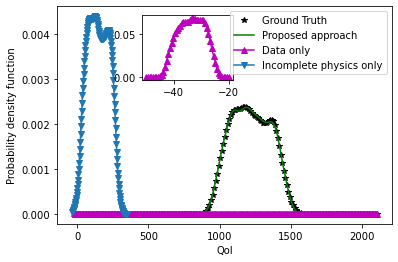

In [23]:
plt.figure(2)
fig2, ax2 = plt.subplots()
q = np.linspace(-35,350,150)
p = np.linspace(-21,2100,350)
ax2.plot(zs,density_p(zs),"*",color ="k", label = "Ground Truth")
ax2.plot(xs,density_p_1(xs),"g", label = "Proposed approach")
ax2.plot(p,density_p_2(p),"-^",color ="m",label = "Data only")
ax2.plot(q,density_p_3(q),"-v",label = "Incomplete physics only")
ax2.set_ylabel('Probability density function')
ax2.set_xlabel('QoI')
ax2_in = ax2.inset_axes([.255,.66, 0.27, 0.3]) 
ax2.legend()
x = np.linspace(-50,-20)
density_p_33 = gaussian_kde(X_hat_data[:,550])
ax2_in.plot(x,density_p_33(x),"-^", color ="m")
plt.savefig('multi_PI_SIR_SDE_PDiffusion_pred1.pdf') 

Hellinger distance

In [22]:
def Hellinger(pdf1,pdf2):
    output =np.sum(np.power(np.sqrt(pdf1)-np.sqrt(pdf2),2))
    return output

In [19]:
from scipy.stats import gaussian_kde
with torch.no_grad():  
    device = torch.device("cuda")
    lambda1 = torch.tensor(-0.5, requires_grad = True).to(device)
    beta1 = torch.tensor(4.0, requires_grad = True).to(device)
    lambda1 = torch.nn.Parameter(lambda1)
    beta1 = torch.nn.Parameter(beta1)
    model_dpc = DNN().to(device)
    model_dpc.register_parameter('lanbda11',lambda1)
    model_dpc.register_parameter('beta1',beta1)
    model_dpc.load_state_dict(torch.load('PIDecoder_SIR_SDE_2k_Pdiffusion'))
    model_dpc.to(device)
    model = Datadriven().to(device)
    model.register_parameter('lanbda11',lambda1)
    model.register_parameter('beta1',beta1) 
    model.load_state_dict(torch.load('PIDecoder_SIR_SDE_2k_Pdiffusion_data'))
    
    nt =1000
    x = np.linspace(-100,2250,350)
    y = np.linspace(-100,2250,350)
    z = np.linspace(-100,2250,350)
    p = np.linspace(-100,2250,350)
    er_dpc=np.zeros([nt])
    er_pd=np.zeros([nt])
    er_pp=np.zeros([nt])
    mae,prm, X_hat, X_hat_data, X_hat_physics, X=test1(model_dpc.double(), model.double(), n=nt)
    for i in range(1,nt):
        density = gaussian_kde(X[:,i])
        density_DPC = gaussian_kde(X_hat[:,i])
        density_PD = gaussian_kde(X_hat_data[:,i])
        density_PP = gaussian_kde(X_hat_physics[:,i])
        er_dpc[i] = Hellinger(density(x),density_DPC(y))
        er_pd[i] = Hellinger(density(x),density_PD(z))
        er_pp[i] = Hellinger(density(x),density_PP(p))
    
    er_dpc_mean = np.mean(er_dpc)
    er_pd_mean = np.mean(er_pd)
    er_pp_mean = np.mean(er_pp)
    print(er_dpc_mean)
    print(er_pd_mean)
    print(er_pp_mean)

(1500, 1000)
(1500, 2)
1.0793861594169013e-05
0.29869509382346815
0.2961528095037682


In [20]:
er_dpc_mean = np.zeros(5)
er_pd_mean = np.zeros(5)
er_pp_mean= np.zeros(5)
for k in range(5):
    from scipy.stats import gaussian_kde
    with torch.no_grad():  
        device = torch.device("cuda")
        lambda1 = torch.tensor(-0.5, requires_grad = True).to(device)
        beta1 = torch.tensor(4.0, requires_grad = True).to(device)
        lambda1 = torch.nn.Parameter(lambda1)
        beta1 = torch.nn.Parameter(beta1)
        model_dpc = DNN().to(device)
        model_dpc.register_parameter('lanbda11',lambda1)
        model_dpc.register_parameter('beta1',beta1)
        model_dpc.load_state_dict(torch.load('PIDecoder_SIR_SDE_2k_Pdiffusion'))
        model_dpc.to(device)
        model = Datadriven().to(device)
        model.register_parameter('lanbda11',lambda1)
        model.register_parameter('beta1',beta1) 
        model.load_state_dict(torch.load('PIDecoder_SIR_SDE_2k_Pdiffusion_data'))

        nt =1000
        x = np.linspace(-100,2250,350)
        y = np.linspace(-100,2250,350)
        z = np.linspace(-100,2250,350)
        p = np.linspace(-100,2250,350)
        er_dpc=np.zeros([nt])
        er_pd=np.zeros([nt])
        er_pp=np.zeros([nt])
        mae,prm, X_hat, X_hat_data, X_hat_physics, X=test1(model_dpc.double(), model.double(), n=nt)
        for i in range(1,nt):
            density = gaussian_kde(X[:,i])
            density_DPC = gaussian_kde(X_hat[:,i])
            density_PD = gaussian_kde(X_hat_data[:,i])
            density_PP = gaussian_kde(X_hat_physics[:,i])
            er_dpc[i] = Hellinger(density(x),density_DPC(y))
            er_pd[i] = Hellinger(density(x),density_PD(z))
            er_pp[i] = Hellinger(density(x),density_PP(p))

        er_dpc_mean[k] = np.mean(er_dpc)
        er_pd_mean[k] = np.mean(er_pd)
        er_pp_mean[k] = np.mean(er_pp)
        print("dpc",er_dpc_mean)
        print("pd",er_pd_mean)
        print("pp",er_pp_mean)
Error_dpc =  np.mean(er_dpc_mean)
Error_pd =  np.mean(er_pd_mean)
Error_pp =  np.mean(er_pp_mean)

print("Error_dpc",Error_dpc)
print("Error_dpc",Error_pd)
print("Error_dpc",Error_pp)

(1500, 1000)
(1500, 2)
dpc [9.70162766e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
pd [0.30292469 0.         0.         0.         0.        ]
pp [0.29615808 0.         0.         0.         0.        ]
(1500, 1000)
(1500, 2)
dpc [9.70162766e-06 8.91714297e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
pd [0.30292469 0.2977371  0.         0.         0.        ]
pp [0.29615808 0.29617001 0.         0.         0.        ]
(1500, 1000)
(1500, 2)
dpc [9.70162766e-06 8.91714297e-06 1.05764136e-05 0.00000000e+00
 0.00000000e+00]
pd [0.30292469 0.2977371  0.29750965 0.         0.        ]
pp [0.29615808 0.29617001 0.29616119 0.         0.        ]
(1500, 1000)
(1500, 2)
dpc [9.70162766e-06 8.91714297e-06 1.05764136e-05 1.03339516e-05
 0.00000000e+00]
pd [0.30292469 0.2977371  0.29750965 0.29569082 0.        ]
pp [0.29615808 0.29617001 0.29616119 0.29616965 0.        ]
(1500, 1000)
(1500, 2)
dpc [9.70162766e-06 8.91714297e-06 1.05764136e-05 1.03339516e-05
 9.77782493e